In [9]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import os


# ==============================
# Config
# ==============================
DATA_DIR = "C:\\Users\\seife\\OneDrive\\Desktop\\MAIM-Internship\\Final_Project\\clean_data"
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 20
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", DEVICE)


# ==============================
# Transforms
# ==============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


# ==============================
# Datasets & Loaders
# ==============================
train_dataset = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_transform)
test_dataset = datasets.ImageFolder(f"{DATA_DIR}/test", transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,       # <--- speed up data loading
    pin_memory=True      # <--- faster transfer to GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

class_names = train_dataset.classes
print("Classes:", class_names)


# ==============================
# Model (ResNet18)
# ==============================
model = models.resnet18(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

model = model.to(DEVICE)
print("Model is on:", next(model.parameters()).device)


# ==============================
# Training Setup
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)


# ==============================
# Training Loop
# ==============================
train_losses, train_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")


# ==============================
# Evaluation
# ==============================
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


✅ Using device: cuda
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is on: cuda:0
Epoch [1/20] Loss: 1.4098, Acc: 47.00%
Epoch [2/20] Loss: 0.9621, Acc: 68.05%
Epoch [3/20] Loss: 0.8163, Acc: 72.21%
Epoch [4/20] Loss: 0.7223, Acc: 76.23%
Epoch [5/20] Loss: 0.6829, Acc: 76.72%
Epoch [6/20] Loss: 0.6528, Acc: 76.97%
Epoch [7/20] Loss: 0.6191, Acc: 78.21%
Epoch [8/20] Loss: 0.6102, Acc: 79.30%
Epoch [9/20] Loss: 0.5918, Acc: 78.55%
Epoch [10/20] Loss: 0.5609, Acc: 81.43%
Epoch [11/20] Loss: 0.5578, Acc: 80.24%
Epoch [12/20] Loss: 0.5406, Acc: 81.62%
Epoch [13/20] Loss: 0.5207, Acc: 81.77%
Epoch [14/20] Loss: 0.5349, Acc: 81.08%
Epoch [15/20] Loss: 0.5086, Acc: 82.57%
Epoch [16/20] Loss: 0.4864, Acc: 83.66%
Epoch [17/20] Loss: 0.4983, Acc: 83.11%
Epoch [18/20] Loss: 0.4924, Acc: 82.71%
Epoch [19/20] Loss: 0.4861, Acc: 83.95%
Epoch [20/20] Loss: 0.4941, Acc: 82.27%

✅ Test Accuracy: 77.76%

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.97      0.84      0.90        81
       glass       0.63      0

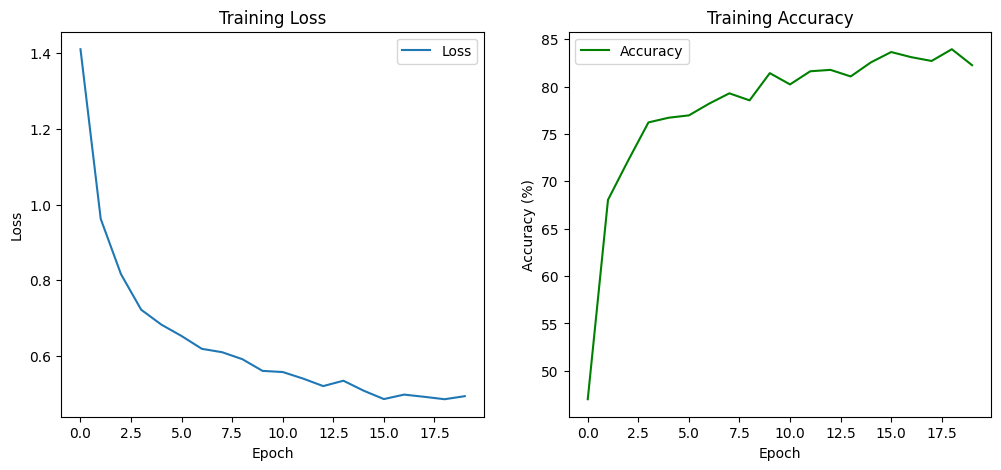

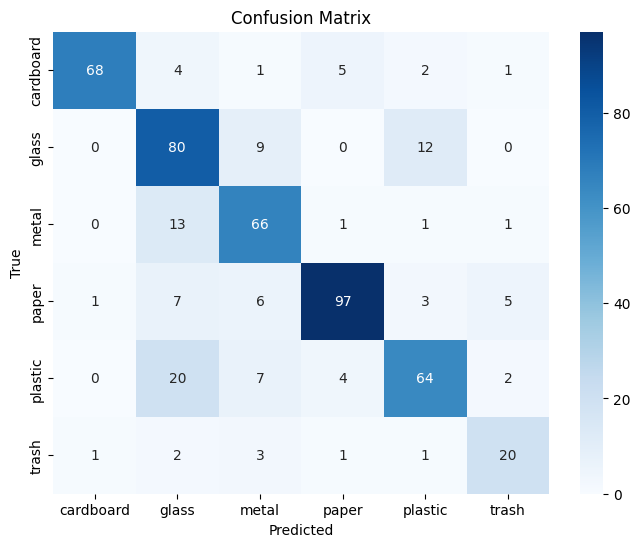

In [11]:
# ==============================
# Visualization
# ==============================
# Plot training loss & accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [13]:
import torch
from ultralytics import YOLO
import os

# ✅ Check device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

# -------------------------
# 1. Load Base Model
# -------------------------
model = YOLO("yolov8n.pt")

# -------------------------
# 2. Dataset Path
# -------------------------
DATA_DIR = r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\detection_data"
DATA_YAML = os.path.join(DATA_DIR, "dataset.yaml")

# -------------------------
# 3. Train Model
# -------------------------
SAVE_DIR = r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models"

results = model.train(
    data=DATA_YAML,
    epochs=30,          # increase to 50+ if dataset is large
    imgsz=640,          # YOLO standard image size
    batch=16,           # adjust for GPU memory
    device=0 if DEVICE == "cuda" else "cpu",
    project=SAVE_DIR,   # ✅ where to save
    name="yolov8_waste" # ✅ subfolder name inside SAVE_DIR
)

# -------------------------
# 4. Evaluate Model
# -------------------------
metrics = model.val()
print("Validation metrics:", metrics)

# -------------------------
# 5. Test on an Image
# -------------------------
test_image = os.path.join(
    DATA_DIR, "images/val/0052.jpg"
)  # replace with an actual test image
results = model.predict(source=test_image, conf=0.5, save=True, device=DEVICE)

# Print detections
for r in results:
    print(r.boxes)  # bounding boxes, confidence, class IDs
    print(r.names)  # class names


Using: cuda
Ultralytics 8.3.191  Python-3.12.3 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\detection_data\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_waste, nbs=64, nms=False, opset=None, optimize=False,

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algor

AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 53.024.2 MB/s, size: 4.6 KB)
train: Scanning C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\detection_data\labels\train.cache... 475 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 475/475 69314.1it/s 0.0s
val: Fast image access  (ping: 0.10.0 ms, read: 5.86.4 MB/s, size: 5.1 KB)
val: Scanning C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\detection_data\labels\val.cache... 119 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 119/119 61902.8it/s 0.0s
Plotting labels to C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models\yolov8_waste\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 datal

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/30      2.29G      0.583      3.107      1.256         30        640: 100% ━━━━━━━━━━━━ 30/30 3.6it/s 8.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 4.9it/s 0.8s0.3s
                   all        119        119     0.0405          1      0.317      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/30      2.46G      0.264      2.624       1.02         47        640: 0% ──────────── 0/30  0.2s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/30      2.47G     0.2727      1.903      1.009         27        640: 100% ━━━━━━━━━━━━ 30/30 6.7it/s 4.4s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.7it/s 0.7s0.3s
                   all        119        119      0.416      0.634      0.563      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/30      2.47G     0.2322      1.563     0.9486         54        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/30      2.48G     0.2247       1.48     0.9638         34        640: 100% ━━━━━━━━━━━━ 30/30 6.9it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.7it/s 0.7s0.3s
                   all        119        119      0.346      0.811      0.524      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/30      2.48G     0.2087      1.378     0.9234         51        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/30      2.48G     0.2162      1.297     0.9505         32        640: 100% ━━━━━━━━━━━━ 30/30 6.8it/s 4.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 4.2it/s 0.9s0.4s
                   all        119        119      0.436      0.794      0.602       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/30      2.48G     0.1862      1.078     0.9516         45        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/30      2.48G     0.2013      1.178     0.9504         31        640: 100% ━━━━━━━━━━━━ 30/30 6.9it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.2it/s 0.8s0.3s
                   all        119        119      0.619        0.8      0.751      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/30      2.48G     0.1528      1.072     0.9337         46        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/30      2.48G     0.1892      1.111     0.9331         39        640: 100% ━━━━━━━━━━━━ 30/30 6.8it/s 4.4s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.5it/s 0.7s0.3s
                   all        119        119      0.657      0.648      0.684      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/30      2.48G     0.2122       1.09     0.9203         52        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/30      2.48G     0.1905      1.069     0.9368         32        640: 100% ━━━━━━━━━━━━ 30/30 7.1it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.2it/s 0.8s0.3s
                   all        119        119      0.652      0.764      0.764       0.75

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/30       2.5G     0.1895     0.9469     0.9536         46        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/30       2.5G     0.1749     0.9986     0.9315         33        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.1it/s 0.8s0.3s
                   all        119        119      0.648      0.835      0.778      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/30      2.51G     0.1571     0.9189     0.9332         49        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/30      2.52G     0.1731     0.9408     0.9313         30        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.2it/s 0.8s0.3s
                   all        119        119      0.809       0.72      0.814      0.806

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/30      2.54G     0.1386     0.8876     0.9165         46        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/30      2.54G     0.1624     0.9431     0.9208         36        640: 100% ━━━━━━━━━━━━ 30/30 6.8it/s 4.4s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.1it/s 0.8s0.3s
                   all        119        119      0.648       0.79      0.795      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/30      2.54G     0.1584      0.791     0.9032         51        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/30      2.54G     0.1443     0.8422     0.9187         30        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.6it/s 0.7s0.3s
                   all        119        119      0.638      0.665      0.761      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/30      2.54G     0.1589     0.8907     0.9423         45        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/30      2.54G     0.1455     0.8511     0.9158         35        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.7it/s 0.7s0.3s
                   all        119        119      0.566      0.783      0.767      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/30      2.54G     0.1252     0.7856     0.8828         48        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/30      2.54G     0.1302     0.7936     0.9116         36        640: 100% ━━━━━━━━━━━━ 30/30 7.1it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.7it/s 0.7s0.3s
                   all        119        119      0.548      0.773      0.733      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/30      2.54G     0.1314     0.9755     0.9367         46        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/30      2.54G     0.1269     0.7699     0.9148         28        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.9it/s 0.7s0.3s
                   all        119        119      0.663      0.759       0.74       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/30      2.54G     0.1219     0.8355     0.9098         46        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/30      2.54G     0.1337     0.7349     0.9189         31        640: 100% ━━━━━━━━━━━━ 30/30 7.3it/s 4.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.8it/s 0.7s0.3s
                   all        119        119       0.63      0.807      0.794      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/30      2.54G      0.123     0.6383     0.9173         48        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/30      2.54G     0.1273     0.7357     0.9126         38        640: 100% ━━━━━━━━━━━━ 30/30 6.8it/s 4.4s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.9it/s 0.7s0.3s
                   all        119        119      0.805      0.871      0.905      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/30      2.54G     0.1242     0.8566     0.8883         52        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/30      2.54G     0.1203     0.6911     0.9035         30        640: 100% ━━━━━━━━━━━━ 30/30 7.0it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.2it/s 0.6s0.3s
                   all        119        119       0.81      0.792      0.882      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/30      2.54G     0.1075      0.701     0.9225         48        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/30      2.54G     0.1158      0.652     0.9122         30        640: 100% ━━━━━━━━━━━━ 30/30 7.2it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.1it/s 0.7s0.3s
                   all        119        119      0.593      0.836      0.779      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/30      2.54G     0.1175     0.7872      0.919         41        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/30      2.54G     0.1046     0.6871     0.9106         31        640: 100% ━━━━━━━━━━━━ 30/30 7.1it/s 4.2s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.1it/s 0.8s0.3s
                   all        119        119      0.682      0.798      0.814      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/30      2.54G     0.1007     0.4967     0.9109         46        640: 0% ──────────── 0/30  0.2s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/30      2.54G     0.1068     0.6455     0.9034         38        640: 100% ━━━━━━━━━━━━ 30/30 6.8it/s 4.4s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.6it/s 0.6s0.2s
                   all        119        119      0.864      0.826      0.907      0.907
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/30      2.54G    0.08247      1.061      0.939         16        640: 0% ──────────── 0/30  0.5s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/30      2.54G     0.1117      0.971     0.9444         11        640: 100% ━━━━━━━━━━━━ 30/30 6.4it/s 4.7s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.3it/s 0.6s0.3s
                   all        119        119      0.775      0.765       0.88       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/30      2.54G     0.1082     0.9212     0.9054         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/30      2.54G    0.08998     0.7609     0.9343         11        640: 100% ━━━━━━━━━━━━ 30/30 6.0it/s 5.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.0it/s 0.7s0.3s
                   all        119        119      0.885      0.782      0.909      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/30      2.54G     0.0733     0.5805     0.9193         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/30      2.54G    0.08599     0.6884     0.9234         11        640: 100% ━━━━━━━━━━━━ 30/30 6.7it/s 4.4s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.3it/s 0.8s0.3s
                   all        119        119      0.766      0.843      0.886      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/30      2.54G    0.08944     0.6936     0.8893         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/30      2.54G    0.07149     0.6485     0.9053         11        640: 100% ━━━━━━━━━━━━ 30/30 6.6it/s 4.5s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.2it/s 0.8s0.3s
                   all        119        119      0.771      0.834      0.884      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/30      2.54G    0.07235     0.6963     0.9331         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/30      2.54G    0.06978     0.5723     0.9083         11        640: 100% ━━━━━━━━━━━━ 30/30 7.3it/s 4.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 5.9it/s 0.7s0.3s
                   all        119        119      0.821      0.848      0.899      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/30      2.54G    0.06187     0.5643     0.9478         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/30      2.54G    0.06202     0.5527     0.9137         11        640: 100% ━━━━━━━━━━━━ 30/30 7.1it/s 4.3s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.2it/s 0.7s0.3s
                   all        119        119      0.843      0.899       0.93       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/30      2.54G    0.05995       0.54      0.918         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/30      2.54G    0.05716     0.5037     0.9184         11        640: 100% ━━━━━━━━━━━━ 30/30 7.2it/s 4.1s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.3it/s 0.6s0.3s
                   all        119        119      0.841      0.873      0.931      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30      2.55G    0.05169     0.7058     0.9374         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/30      2.55G    0.04969     0.4849     0.9229         11        640: 100% ━━━━━━━━━━━━ 30/30 7.2it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.7it/s 0.6s0.2s
                   all        119        119      0.875      0.864      0.919      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30      2.55G    0.06413     0.4834     0.8805         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/30      2.55G    0.04984     0.4669     0.9106         11        640: 100% ━━━━━━━━━━━━ 30/30 7.1it/s 4.2s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.4it/s 0.6s0.2s
                   all        119        119      0.888      0.872      0.912      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/30      2.55G     0.0498     0.3552     0.8706         16        640: 0% ──────────── 0/30  0.1s<

c:\Users\seife\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\utils\loss.py:240: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/30      2.55G    0.04818     0.4211     0.9048         11        640: 100% ━━━━━━━━━━━━ 30/30 7.2it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 6.3it/s 0.6s0.3s
                   all        119        119      0.907      0.848      0.925      0.925

30 epochs completed in 0.051 hours.
Optimizer stripped from C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models\yolov8_waste\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models\yolov8_waste\weights\best.pt, 6.2MB

Validating C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models\yolov8_waste\weights\best.pt...
Ultralytics 8.3.191  Python-3.12.3 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R  

Using: cuda


Epoch 1/20: 100%|██████████| 64/64 [00:03<00:00, 18.48it/s]


Epoch [1/20] Loss: 0.0202
💾 Best model saved with loss 0.0202


Epoch 2/20: 100%|██████████| 64/64 [00:03<00:00, 18.57it/s]


Epoch [2/20] Loss: 0.0066
💾 Best model saved with loss 0.0066


Epoch 3/20: 100%|██████████| 64/64 [00:03<00:00, 18.28it/s]


Epoch [3/20] Loss: 0.0047
💾 Best model saved with loss 0.0047


Epoch 4/20: 100%|██████████| 64/64 [00:03<00:00, 19.04it/s]


Epoch [4/20] Loss: 0.0040
💾 Best model saved with loss 0.0040


Epoch 5/20: 100%|██████████| 64/64 [00:03<00:00, 19.25it/s]


Epoch [5/20] Loss: 0.0034
💾 Best model saved with loss 0.0034


Epoch 6/20: 100%|██████████| 64/64 [00:03<00:00, 19.11it/s]


Epoch [6/20] Loss: 0.0033
💾 Best model saved with loss 0.0033


Epoch 7/20: 100%|██████████| 64/64 [00:03<00:00, 18.96it/s]


Epoch [7/20] Loss: 0.0031
💾 Best model saved with loss 0.0031


Epoch 8/20: 100%|██████████| 64/64 [00:03<00:00, 19.04it/s]


Epoch [8/20] Loss: 0.0031
💾 Best model saved with loss 0.0031


Epoch 9/20: 100%|██████████| 64/64 [00:03<00:00, 19.43it/s]


Epoch [9/20] Loss: 0.0030
💾 Best model saved with loss 0.0030


Epoch 10/20: 100%|██████████| 64/64 [00:03<00:00, 19.42it/s]


Epoch [10/20] Loss: 0.0028
💾 Best model saved with loss 0.0028


Epoch 11/20: 100%|██████████| 64/64 [00:03<00:00, 18.37it/s]


Epoch [11/20] Loss: 0.0028
💾 Best model saved with loss 0.0028


Epoch 12/20: 100%|██████████| 64/64 [00:03<00:00, 18.33it/s]


Epoch [12/20] Loss: 0.0027
💾 Best model saved with loss 0.0027


Epoch 13/20: 100%|██████████| 64/64 [00:03<00:00, 18.84it/s]


Epoch [13/20] Loss: 0.0027


Epoch 14/20: 100%|██████████| 64/64 [00:03<00:00, 18.86it/s]


Epoch [14/20] Loss: 0.0026
💾 Best model saved with loss 0.0026


Epoch 15/20: 100%|██████████| 64/64 [00:03<00:00, 18.77it/s]


Epoch [15/20] Loss: 0.0024
💾 Best model saved with loss 0.0024


Epoch 16/20: 100%|██████████| 64/64 [00:03<00:00, 19.04it/s]


Epoch [16/20] Loss: 0.0024
💾 Best model saved with loss 0.0024


Epoch 17/20: 100%|██████████| 64/64 [00:03<00:00, 18.98it/s]


Epoch [17/20] Loss: 0.0024
💾 Best model saved with loss 0.0024


Epoch 18/20: 100%|██████████| 64/64 [00:03<00:00, 18.23it/s]


Epoch [18/20] Loss: 0.0025


Epoch 19/20: 100%|██████████| 64/64 [00:03<00:00, 18.89it/s]


Epoch [19/20] Loss: 0.0023
💾 Best model saved with loss 0.0023


Epoch 20/20: 100%|██████████| 64/64 [00:03<00:00, 18.98it/s]


Epoch [20/20] Loss: 0.0023
💾 Best model saved with loss 0.0023


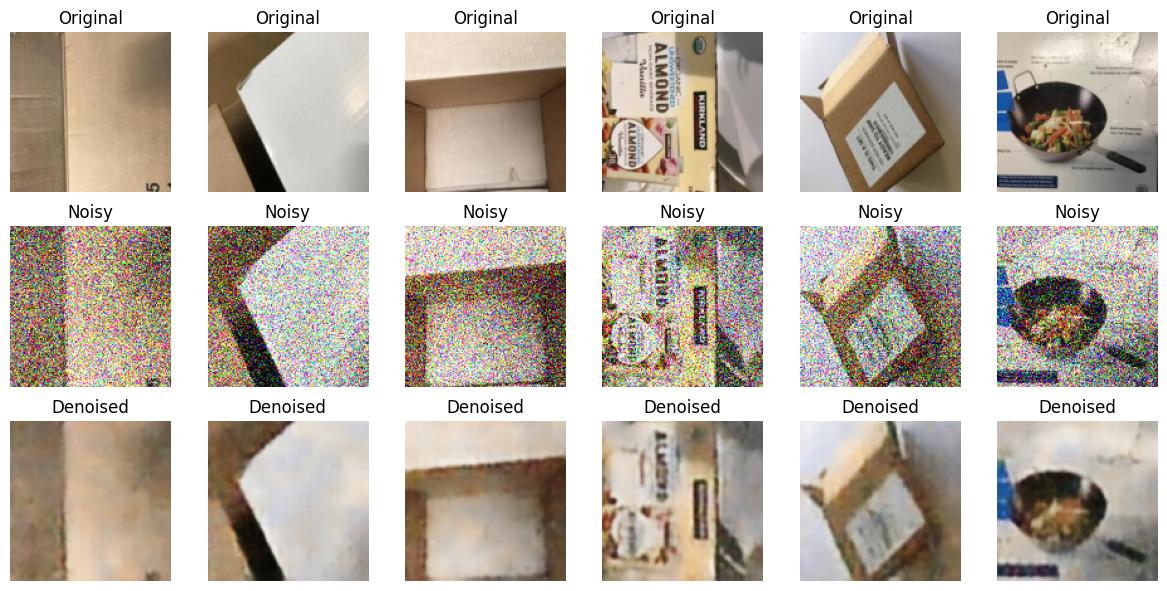

✅ Training complete. Final model saved to C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models\dae.pth


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
DATA_DIR = r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\clean_data"
MODEL_DIR = r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\models"
os.makedirs(MODEL_DIR, exist_ok=True)

BATCH_SIZE = 32
IMG_SIZE = 128
EPOCHS = 20
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

# -------------------------
# Transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# Add Noise Function
# -------------------------
def add_noise(imgs, noise_factor=0.3):
    noisy = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clamp(noisy, 0.0, 1.0)

# -------------------------
# Autoencoder Model
# -------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# -------------------------
# Training Setup
# -------------------------
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
best_loss = float("inf")
MODEL_PATH = os.path.join(MODEL_DIR, "dae.pth")

# -------------------------
# Training Loop
# -------------------------
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(DEVICE)
        noisy_imgs = add_noise(imgs).to(DEVICE)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss:.4f}")

    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"💾 Best model saved with loss {best_loss:.4f}")

# -------------------------
# Evaluation + Visualization
# -------------------------
model.eval()
dataiter = iter(test_loader)
images, _ = next(dataiter)
noisy_images = add_noise(images).to(DEVICE)

with torch.no_grad():
    outputs = model(noisy_images)

# move back to CPU + numpy for plotting
images = images.numpy().transpose((0, 2, 3, 1))
noisy_images = noisy_images.cpu().numpy().transpose((0, 2, 3, 1))
outputs = outputs.cpu().numpy().transpose((0, 2, 3, 1))

# Show results
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i in range(6):
    axes[0, i].imshow(images[i])
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(noisy_images[i])
    axes[1, i].set_title("Noisy")
    axes[1, i].axis("off")

    axes[2, i].imshow(outputs[i])
    axes[2, i].set_title("Denoised")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

print(f"✅ Training complete. Final model saved to {MODEL_PATH}")


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# -------------------------
# Config
# -------------------------
DATA_DIR = (
    r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\clean_data\train"
)
SAVE_DIR = (
    r"C:\Users\seife\OneDrive\Desktop\MAIM-Internship\Final_Project\generated_data"
)

os.makedirs(SAVE_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 64  # GANs usually work on 64x64
BATCH_SIZE = 128
EPOCHS = 200
LATENT_DIM = 100
LR = 0.0002
BETA1 = 0.5  # recommended for GANs

# -------------------------
# Data (train only)
# -------------------------
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # normalize to [-1, 1]
    ]
)

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

num_classes = len(dataset.classes)
print("Classes:", dataset.classes)


# -------------------------
# Generator
# -------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)


# -------------------------
# Discriminator
# -------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.net(img).view(-1, 1).squeeze(1)


# -------------------------
# Init models
# -------------------------
generator = Generator(LATENT_DIM).to(DEVICE)
discriminator = Discriminator().to(DEVICE)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))

# -------------------------
# Training Loop
# -------------------------
for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(DEVICE)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.full((batch_size,), 0.9, device=DEVICE)
        fake_labels = torch.zeros(batch_size, device=DEVICE)

        # -------------------------
        # Train Discriminator
        # -------------------------
        z = torch.randn(batch_size, LATENT_DIM, 1, 1, device=DEVICE)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # -------------------------
        # Train Generator
        # -------------------------
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}"
    )

    # Save ONE sample image every 20 epochs
    if (epoch + 1) % 20 == 0:
        z = torch.randn(1, LATENT_DIM, 1, 1, device=DEVICE)  # only 1 noise vector
        sample = generator(z)
        save_image(
            sample,
            os.path.join(SAVE_DIR, f"epoch_{epoch+1}_sample.png"),
            normalize=True,
        )


# -------------------------
# Save Generator
# -------------------------
torch.save(
    generator.state_dict(),
    os.path.join(
        "C:\\Users\\seife\\OneDrive\\Desktop\\MAIM-Internship\\Final_Project\\models",
        "gan_generator.pth",
    ),
)
print("✅ Generator model saved to models/gan_generator.pth")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Epoch [1/200] D_loss: 0.2407 G_loss: 7.0128
Epoch [2/200] D_loss: 0.2508 G_loss: 12.9780
Epoch [3/200] D_loss: 0.9805 G_loss: 12.1406
Epoch [4/200] D_loss: 0.5148 G_loss: 7.7863
Epoch [5/200] D_loss: 0.4200 G_loss: 3.1559
Epoch [6/200] D_loss: 0.2434 G_loss: 3.4443
Epoch [7/200] D_loss: 0.2548 G_loss: 3.1450
Epoch [8/200] D_loss: 0.2650 G_loss: 3.6758
Epoch [9/200] D_loss: 0.2526 G_loss: 2.4402
Epoch [10/200] D_loss: 0.5057 G_loss: 3.8056
Epoch [11/200] D_loss: 0.4913 G_loss: 2.5295
Epoch [12/200] D_loss: 0.3616 G_loss: 4.0110
Epoch [13/200] D_loss: 0.3462 G_loss: 4.2099
Epoch [14/200] D_loss: 0.3515 G_loss: 2.8658
Epoch [15/200] D_loss: 0.8799 G_loss: 2.6447
Epoch [16/200] D_loss: 0.3113 G_loss: 3.6365
Epoch [17/200] D_loss: 0.8224 G_loss: 0.8370
Epoch [18/200] D_loss: 0.3831 G_loss: 2.3744
Epoch [19/200] D_loss: 0.3686 G_loss: 1.6532
Epoch [20/200] D_loss: 0.3037 G_loss: 2.2173
Epoch [21/200] D_loss: 0.3343 G_loss: